In [1]:
import xarray as xr

working_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/"
nasa_l3= xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']
mf_l3 = xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']
nasa_pseudo_l3=xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']
s2_theia=xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_s2_theia_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/analyses/confusion_table'
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True)

0.7579879583320059
0.038912007054868136


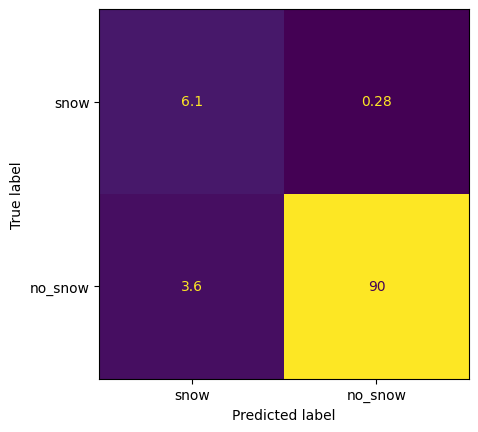

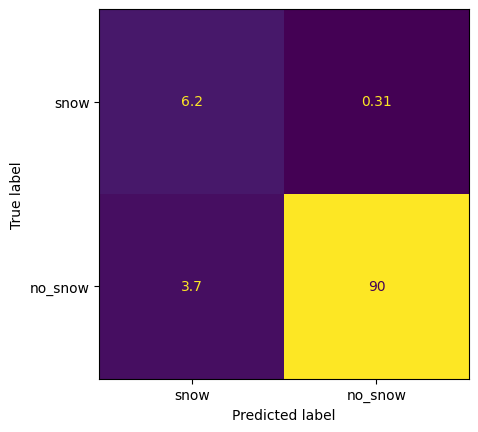

In [ ]:
from reductions.confusion_table import plot_confusion_table

import numpy as np
import rasterio.enums
from grids import UTM375mGrid
from reprojections import reproject_using_grid
import xarray as xr
import rasterio 
from reductions.confusion_table import compute_score

test_ts = mf_l3.sel(time='2024-01-25')
ref_ts = s2_theia.sel(time='2024-01-25')

# common_days = np.intersect1d(test_ts["time"], ref_ts["time"])
# test_ts = test_ts.sel(time=common_days)
# ref_ts = ref_ts.sel(time=common_days)

test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=200).astype(np.uint8)
test_snow = test_snow + (test_ts==210).astype(np.uint8)
test_no_snow = (test_ts == 0).astype(np.uint8) | (test_ts == 215).astype(np.uint8) 
ref_no_snow = (ref_ts == 0).astype(np.uint8)
test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=200).astype(np.uint8)
test_snow = test_snow + (test_ts==210).astype(np.uint8)
ref_snow = (ref_ts > 0).astype(np.uint8) & (ref_ts<=100).astype(np.uint8)
test_snow = test_snow.astype(bool)
ref_snow = ref_snow.astype(bool)
test_no_snow = test_no_snow.astype(bool)
ref_no_snow = ref_no_snow.astype(bool)
conf_matrix_ds = xr.Dataset(
    {
    'true_positive': test_snow & ref_snow,
    'true_negative': test_no_snow & ref_no_snow,
    'false_positive': test_snow & ref_no_snow,
    'false_negative': test_no_snow & ref_snow,
    }
)
plot_confusion_table(conf_matrix_ds)
plot_confusion_table(mf_metrics_ds.sel(time='2024-01-25'))
print(compute_score(conf_matrix_ds, 'f1_score').values)
print(compute_score(conf_matrix_ds, 'false_alarm_rate').values)

Météo-France

0.8137531328320802
0.014947501860170308


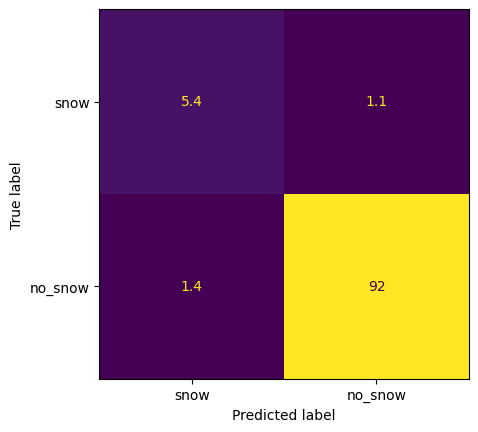

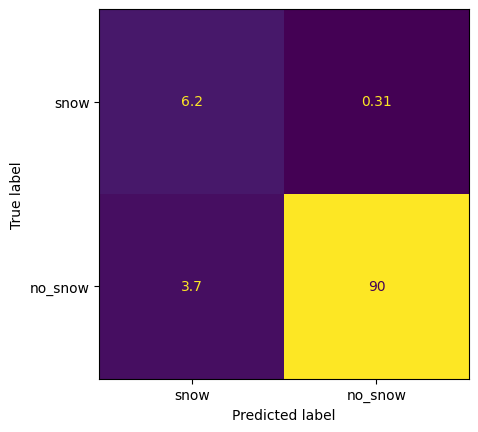

In [ ]:
from reductions.confusion_table import plot_confusion_table

import numpy as np
import rasterio.enums
from grids import UTM375mGrid
from reprojections import reproject_using_grid
import xarray as xr
import rasterio 
from reductions.confusion_table import compute_score
ccnp = xr.open_dataarray('/home/imperatoren/work/VIIRS_S2_comparison/data/CMS_rejeu/202401/20240125_125923_npp_lzw_CCNPPJSNOW_reproj.tif')
# conf_matrix_ds.data_vars['false_positive'].to_netcdf('false_positive_mf_20240125.nc')
ccnp_utm = reproject_using_grid(ccnp, UTM375mGrid(),resampling_method=rasterio.enums.Resampling.nearest)
low_refl_mask = ccnp_utm.sel(band=1) < 40
test_ts = mf_l3.sel(time='2024-01-25')
test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=200).astype(np.uint8)
test_snow = test_snow + (test_ts==210).astype(np.uint8)
(low_refl_mask & test_snow).to_netcdf('low_ref_mask_snow_cover.nc')


ref_ts = s2_theia.sel(time='2024-01-25')
test_ts = test_ts.where(test_ts > 210, test_ts.where(1 - low_refl_mask, 0))
# common_days = np.intersect1d(test_ts["time"], ref_ts["time"])
# test_ts = test_ts.sel(time=common_days)
# ref_ts = ref_ts.sel(time=common_days)

test_no_snow = (test_ts == 0).astype(np.uint8) | (test_ts == 215).astype(np.uint8) 
ref_no_snow = (ref_ts == 0).astype(np.uint8)
test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=200).astype(np.uint8)
test_snow = test_snow + (test_ts==210).astype(np.uint8)
ref_snow = (ref_ts > 0).astype(np.uint8) & (ref_ts<=100).astype(np.uint8)
test_snow = test_snow.astype(bool)
ref_snow = ref_snow.astype(bool)
test_no_snow = test_no_snow.astype(bool)
ref_no_snow = ref_no_snow.astype(bool)
conf_matrix_ds = xr.Dataset(
    {
    'true_positive': test_snow & ref_snow,
    'true_negative': test_no_snow & ref_no_snow,
    'false_positive': test_snow & ref_no_snow,
    'false_negative': test_no_snow & ref_snow,
    }
)
plot_confusion_table(conf_matrix_ds)
plot_confusion_table(mf_metrics_ds.sel(time='2024-01-25'))
print(compute_score(conf_matrix_ds, 'f1_score').values)
print(compute_score(conf_matrix_ds, 'false_alarm_rate').values)

In [ ]:
import rasterio.enums
from grids import UTM375mGrid
from reprojections import reproject_using_grid
import xarray as xr
import rasterio 
ccnp = xr.open_dataarray('/home/imperatoren/work/VIIRS_S2_comparison/data/CMS_rejeu/202401/20240125_125923_npp_lzw_CCNPPJSNOW_reproj.tif')
# conf_matrix_ds.data_vars['false_positive'].to_netcdf('false_positive_mf_20240125.nc')
ccnp_utm = reproject_using_grid(ccnp, UTM375mGrid(),resampling_method=rasterio.enums.Resampling.nearest)
low_refl_mask = np.sqrt(ccnp_utm.sel(band=1)**2 + ccnp_utm.sel(band=2)**2 + ccnp_utm.sel(band=3)**2) <50
low_refl_mask = low_refl_mask & (test_snow)
# ccnp_utm.to_netcdf()

In [ ]:

low_refl_mask.to_netcdf('low_refl_mask_20240125.nc')

NASA L3

0.8155202489274433
0.015809012447958723


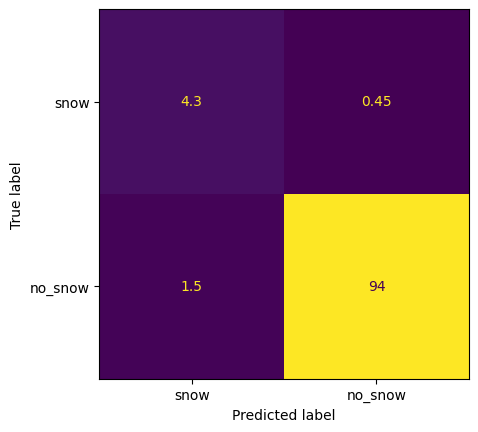

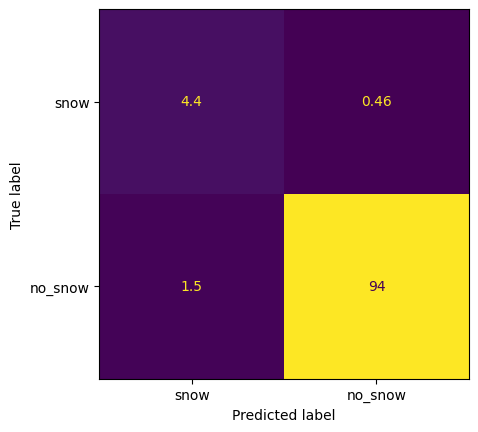

In [73]:

test_ts = nasa_l3.sel(time='2024-01-25')
ref_ts = s2_theia.sel(time='2024-01-25')
# common_days = np.intersect1d(test_ts["time"], ref_ts["time"])
# test_ts = test_ts.sel(time=common_days)
# ref_ts = ref_ts.sel(time=common_days)

test_no_snow = (test_ts == 0).astype(np.uint8)
ref_no_snow = (ref_ts == 0).astype(np.uint8)
test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=100).astype(np.uint8)
ref_snow = (ref_ts > 0).astype(np.uint8) & (ref_ts<=100).astype(np.uint8)
test_snow = test_snow.astype(bool)
ref_snow = ref_snow.astype(bool)
test_no_snow = test_no_snow.astype(bool)
ref_no_snow = ref_no_snow.astype(bool)
conf_matrix_ds = xr.Dataset(
    {
    'true_positive': test_snow & ref_snow,
    'true_negative': test_no_snow & ref_no_snow,
    'false_positive': test_snow & ref_no_snow,
    'false_negative': test_no_snow & ref_snow,
    }
)
plot_confusion_table(conf_matrix_ds)
plot_confusion_table(nasa_l3_metrics_ds.sel(time='2024-01-25'))
print(compute_score(conf_matrix_ds, 'f1_score').values)
print(compute_score(conf_matrix_ds, 'false_alarm_rate').values)

NASA pseudo L3

0.9127696092453802
0.03285029642236711


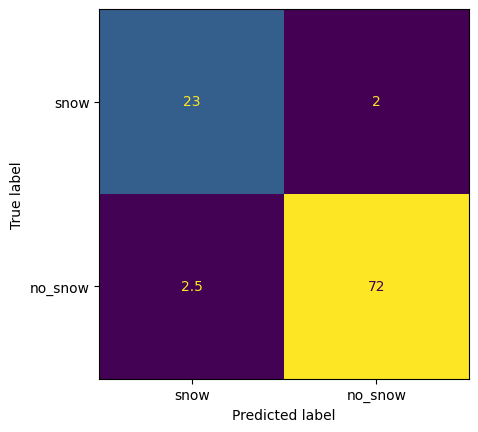

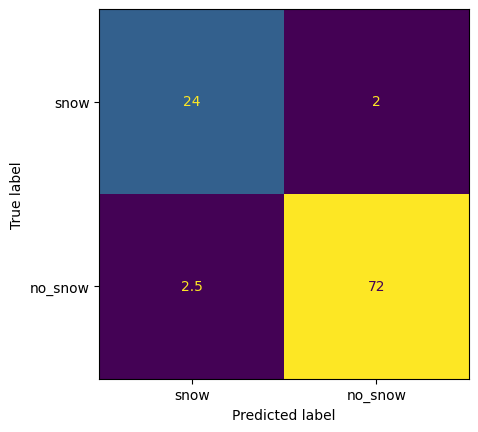

In [65]:

test_ts = nasa_pseudo_l3.sel(time='2024-01')
ref_ts = s2_theia.sel(time='2024-01')
common_days = np.intersect1d(test_ts["time"], ref_ts["time"])
test_ts = test_ts.sel(time=common_days)
ref_ts = ref_ts.sel(time=common_days)

test_no_snow = (test_ts == 0).astype(np.uint8)
ref_no_snow = (ref_ts == 0).astype(np.uint8)
test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=100).astype(np.uint8)
ref_snow = (ref_ts > 0).astype(np.uint8) & (ref_ts<=100).astype(np.uint8)
test_snow = test_snow.astype(bool)
ref_snow = ref_snow.astype(bool)
test_no_snow = test_no_snow.astype(bool)
ref_no_snow = ref_no_snow.astype(bool)
conf_matrix_ds = xr.Dataset(
    {
    'true_positive': test_snow & ref_snow,
    'true_negative': test_no_snow & ref_no_snow,
    'false_positive': test_snow & ref_no_snow,
    'false_negative': test_no_snow & ref_snow,
    }
)
plot_confusion_table(conf_matrix_ds)
plot_confusion_table(nasa_pseudo_l3_metrics_ds.sel(time='2024-01'))
print(compute_score(conf_matrix_ds, 'f1_score').values)
print(compute_score(conf_matrix_ds, 'false_alarm_rate').values)

In [48]:
dem_path="/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem/DEM_MSF_UTM31_375m_lanczos.tif"
dem = xr.open_dataarray(dem_path).sel(band=1)
dem_mask = dem>2100

test_ts = mf_l3.sel(time='2023-12').where(dem_mask)

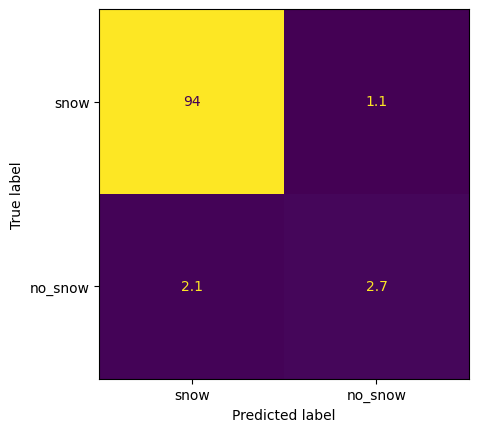

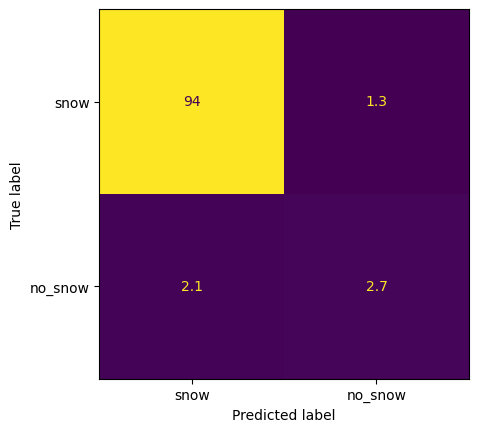

In [59]:
# Altitude test

dem_path="/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem/DEM_MSF_UTM31_375m_lanczos.tif"
dem = xr.open_dataarray(dem_path).sel(band=1)
dem_mask = dem>=2100

test_ts = mf_l3.sel(time='2023-12').where(dem_mask)
ref_ts = s2_theia.sel(time='2023-12').where(dem_mask)

common_days = np.intersect1d(test_ts["time"], ref_ts["time"])
test_ts = test_ts.sel(time=common_days)
ref_ts = ref_ts.sel(time=common_days)

test_no_snow = (test_ts == 0).astype(np.uint8) + (test_ts == 215).astype(np.uint8) 
ref_no_snow = (ref_ts == 0).astype(np.uint8)
test_snow = (test_ts > 0).astype(np.uint8) & (test_ts<=200).astype(np.uint8)
test_snow = test_snow + (test_ts==210).astype(np.uint8)
ref_snow = (ref_ts > 0).astype(np.uint8) & (ref_ts<=100).astype(np.uint8)
test_snow = test_snow.astype(bool)
ref_snow = ref_snow.astype(bool)
test_no_snow = test_no_snow.astype(bool)
ref_no_snow = ref_no_snow.astype(bool)
conf_matrix_ds = xr.Dataset(
    {
    'true_positive': test_snow & ref_snow,
    'true_negative': test_no_snow & ref_no_snow,
    'false_positive': test_snow & ref_no_snow,
    'false_negative': test_no_snow & ref_snow,
    }
)
plot_confusion_table(conf_matrix_ds)
plot_confusion_table(mf_metrics_ds.sel(time='2023-12', altitude_bins=slice(2700,None)))

In [2]:
import xarray as xr

from products.plot_settings import METEOFRANCE_VAR_NAME, NASA_L3_VAR_NAME, NASA_PSEUDO_L3_VAR_NAME

working_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/"
nasa_l3= xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']
mf_l3 = xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']
nasa_pseudo_l3=xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']
s2_theia=xr.open_dataset(f"{working_folder}/time_series/WY_2023_2024_s2_theia_res_375m.nc", decode_cf=True).data_vars['snow_cover_fraction']

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/analyses/uncertainty'
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/uncertainty_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/uncertainty_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/uncertainty_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True)
analyses_dict = {METEOFRANCE_VAR_NAME: mf_metrics_ds, NASA_PSEUDO_L3_VAR_NAME: nasa_pseudo_l3_metrics_ds, NASA_L3_VAR_NAME: nasa_l3_metrics_ds}

In [ ]:
from reductions.statistics_base import EvaluationVsHighResBase
from reductions.uncertainty import postprocess_uncertainty_analysis

selection_dict = {k: v.sel(time=slice('2023-12-01', '2024-01-31')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
postproc_ds = postprocess_uncertainty_analysis(selection_dict, analysis_var='aspect_bins')

In [37]:
postproc_ds.sel(product='meteofrance_l3').sel(aspect_bins='N')

<xarray.Dataset> Size: 84B
Dimensions:         ()
Coordinates:
    aspect_bins     <U1 4B 'N'
    product         <U14 56B 'meteofrance_l3'
Data variables:
    biais           float64 8B 7.08
    rmse            float64 8B 21.26
    unbiaised_rmse  float64 8B 20.05

In [38]:
import numpy as np

aspect_map_path="/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem/ASP_MSF_UTM31_375m_lanczos.tif"
dem_path="/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem/DEM_MSF_UTM31_375m_lanczos.tif"

aspect_map = xr.open_dataarray(aspect_map_path)
aspect_mask = (aspect_map>337.5).astype(np.uint8) | (aspect_map<=22.5).astype(np.uint8)

altitude_map = xr.open_dataarray(dem_path)
altitude_mask = altitude_map>1500

mf_sel = mf_l3.sel(time=slice('2023-12-01', '2024-01-31')).where(altitude_mask).where(aspect_mask)
s2_sel = s2_theia.sel(time=slice('2023-12-01', '2024-01-31')).where(altitude_mask).where(aspect_mask)

mf = mf_sel.where(mf_sel<=200) /2
s2 = s2_sel.where(s2_sel<=100) 

biais = (mf - s2).mean()
rmse = np.sqrt(((mf - s2)**2).mean())

print(biais.values, rmse.values)

6.961479 21.253872
